In [20]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [21]:
#2. Read data
import yfinance as yf

data = yf.download(tickers = "GC=F", start="2017-12-01", end="2023-06-16", interval='1d')

[*********************100%***********************]  1 of 1 completed


In [22]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,1274.099976,1288.599976,1271.000000,1278.800049,1278.800049,823
2017-12-04,1272.500000,1276.099976,1270.300049,1274.300049,1274.300049,850
2017-12-05,1275.400024,1275.800049,1260.000000,1261.599976,1261.599976,1499
2017-12-06,1264.900024,1267.800049,1261.599976,1262.800049,1262.800049,373
2017-12-07,1262.300049,1262.400024,1243.900024,1249.800049,1249.800049,358
...,...,...,...,...,...,...
2023-06-09,1965.099976,1969.800049,1960.300049,1962.199951,1962.199951,49
2023-06-12,1959.699951,1963.500000,1951.400024,1955.300049,1955.300049,212
2023-06-13,1960.599976,1967.500000,1940.300049,1944.599976,1944.599976,343


In [23]:
data = data.reset_index('Date', inplace=False)

In [24]:
df = data

In [25]:
df1=df.reset_index()['Close']

In [26]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [27]:
# 4. Split train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [28]:
# 5. Function Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [30]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [31]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
# 9. Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 63ms/step - loss: 0.1430 - val_loss: 0.0107
Epoch 2/100
14/14 [==============================] - 1s 64ms/step - loss: 0.0233 - val_loss: 0.0017
Epoch 3/100
14/14 [==============================] - 1s 36ms/step - loss: 0.0107 - val_loss: 0.0090
Epoch 4/100
14/14 [==============================] - 1s 37ms/step - loss: 0.0055 - val_loss: 9.3303e-04
Epoch 5/100
14/14 [==============================] - 1s 38ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 6/100
14/14 [==============================] - 1s 37ms/step - loss: 0.0011 - val_loss: 9.2424e-04
Epoch 7/100
14/14 [==============================] - 0s 36ms/step - loss: 7.9241e-04 - val_loss: 8.9658e-04
Epoch 8/100
14/14 [==============================] - 1s 51ms/step - loss: 7.7837e-04 - val_loss: 9.4856e-04
Epoch 9/100
14/14 [==============================] - 1s 60ms/step - loss: 7.6381e-04 - val_loss: 8.1817e-04
Epoch 10/100
14/14 [==============================] - 1s 54ms/step -

In [33]:
# 10. Test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 14ms/step


In [34]:
# 11. Normalization y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [35]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [40]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 17.794135157890697
Validation RMSE: 14.78011371299404
Testing MAE: 13.94197522179556
Validation MAE: 12.055807495117183
Testing MAPE: 0.007837141652439115
Validation MAPE: 0.0060631250091413595


In [37]:
# 13. Predict 30 days after
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0

while i < 30:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[:n_steps])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        padding = n_steps - len(temp_input)
        x_input = np.array(temp_input + [0] * padding)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

[-0.00122563]
[-0.00122557]
[-0.00122547]
[-0.00122531]
[-0.00122509]
[-0.00122476]
[-0.00122432]
[-0.00122378]
[-0.00122322]
[-0.00122289]
[-0.00122337]
[-0.00122584]
[-0.00123265]
[-0.00124816]
[-0.00128039]
[-0.00134413]
[-0.00146727]
[-0.00170456]
[-0.00216532]
19 day input [ 0.75037132  0.74922885  0.73323433  0.72272371  0.73209187  0.74568724
  0.75574085  0.75094255  0.7671655   0.76739408  0.72855025  0.72717921
  0.74614425  0.78350281  0.84028328  0.83399972  0.85730605  0.84862334
  0.90666063  0.9173997   0.87033018  0.88038393  0.9340798   0.92071287
  0.88678171  0.90963102  0.90243343  0.91865652  0.90574661  0.92276937
  0.96652571  0.96504059  0.9547584   0.92871013  0.94664692  0.95361593
  0.98834691  0.9436764   0.93453668  0.9496173   0.93567914  0.94984574
  0.91774249  0.92871013  0.93430824  0.92482572  0.92962416  0.9298526
  0.92219814  0.95750034  0.97383751  0.99600137  0.96104196  0.97120993
  0.98252022  0.97600823  0.95795722  0.95772878  0.96172741  0.9

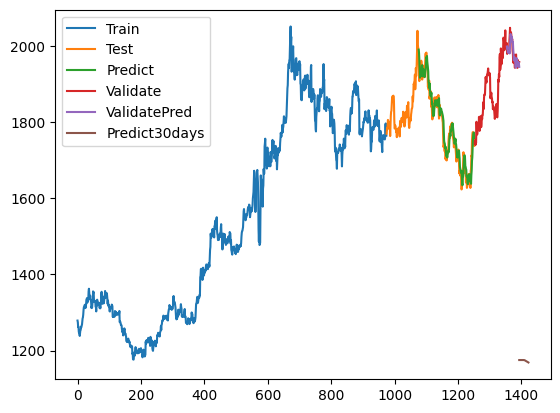

In [38]:
# 14.Plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()